In [10]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from adtxns_utils import *

In [11]:
# Define a wrapper function for saving figures with bbox_inches='tight'
def save_figure(fig, filename):
    fig.savefig(filename, bbox_inches='tight')


# fig_path = '/home/claudio/tesi/manuscript/final_figures'
fig_path = './figures'
# fig_path = './wait'

save = True
put_title = True

In [12]:

# def std_rc():
#     b = 5.5
#     plt.rcParams.update({
#         "text.usetex": True,           # Enable LaTeX for text rendering
#         "font.family": "serif",        # Use serif font
#         "font.size":20,               # Set font size
#         # "figure.figsize": (10, 10/1.5), # Figure size (matches LaTeX document width)
#         # 'figure.figsize': (b,b),
#         "figure.dpi": 100,             # High resolution for clarity
#         "savefig.dpi": 500,            # High resolution for saving
#         "axes.linewidth": 1.0,         # Thickness of axes lines
#         "axes.grid": True,             # Enable grid globally
#         "axes.grid.which": "major",    # Apply grid to both major and minor ticks
#         "grid.color": "gray",          # Grid line color
#         "grid.linestyle": "-",         # Grid line style
#         "grid.linewidth": 0.2,         # Grid line thickness
#         "grid.alpha": 0.7,             # Grid transparency
#         "axes.labelweight": "bold",    # Bold axis labels
#         "axes.labelsize":18,
#         "axes.titleweight": "bold",    # Bold titles
#         "legend.fontsize": "large",    # Larger legend text
#         "xtick.labelsize":20,         # X-tick label size
#         "ytick.labelsize":20,         # Y-tick label size
#         "xtick.direction": "in",       # Ticks pointing inwards
#         "ytick.direction": "in",
#         "xtick.major.size": 5,         # Major tick size
#         "ytick.major.size": 5,
#         "xtick.minor.size": 3,         # Minor tick size
#         "ytick.minor.size": 3,
#         "legend.fontsize":18,
#         "legend.frameon": True,
#         "legend.framealpha": 0.8,    # Transparency of legend box (1 = opaque, 0 = fully transparent)
#         "legend.facecolor": "white", # Background color of the legend box
#         # "legend.edgecolor": "black", # Border color of the legend box
#         "legend.borderpad": 0.3,     # Padding inside the legend box
#         "legend.labelspacing": 0.3,  # Space between legend entries
#         "legend.handlelength": 2,    # Length of legend handles (line, marker)
#         "legend.handletextpad": 0.5, # Space between handle and label
#         "legend.loc": "best",        # Default position of the legend
#         "legend.columnspacing": 1.0, # Space between legend columns
#         "lines.markeredgecolor": "black", # Marker edge color
#         "lines.markeredgewidth": 0.8, # Marker edge width
#         "lines.markersize": 6,        # Marker size

#     })

# std_rc()


In [13]:
# ! New rc
def std_rc(ax_size=(6, 4), margins=None):
    if margins is None:
        margins = {"left": 0.15, "right": 0.95, "bottom": 0.15, "top": 0.95}

    # calcolo la dimensione della figura per ottenere assi di dimensione costante
    fig_w = ax_size[0] / (margins["right"] - margins["left"])
    fig_h = ax_size[1] / (margins["top"] - margins["bottom"])

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 20,
        "figure.figsize": (fig_w, fig_h),
        "figure.dpi": 100,
        "savefig.dpi": 500,
        "axes.linewidth": 1.0,
        "axes.grid": True,
        "axes.grid.which": "major",
        "grid.color": "gray",
        "grid.linestyle": "-",
        "grid.linewidth": 0.2,
        "grid.alpha": 0.7,
        "axes.labelweight": "bold",
        "axes.labelsize": 18,
        "axes.titleweight": "bold",
        "axes.labelpad": 10,

        "legend.fontsize": 18,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 5,
        "ytick.major.size": 5,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,
        "legend.frameon": True,
        "legend.framealpha": 0.8,
        "legend.facecolor": "white",
        "legend.borderpad": 0.3,
        "legend.labelspacing": 0.3,
        "legend.handlelength": 2,
        "legend.handletextpad": 0.5,
        "legend.loc": "best",
        "legend.columnspacing": 1.0,
        "lines.markeredgecolor": "black",
        "lines.markeredgewidth": 0.8,
        "lines.markersize": 6,
        # margini
        "figure.subplot.left": margins["left"],
        "figure.subplot.right": margins["right"],
        "figure.subplot.bottom": margins["bottom"],
        "figure.subplot.top": margins["top"],
    })

std_rc((6,6))


# Sarafu handling


In [14]:
txns_fn = '/home/claudio/tesi/sarafu/final_data/00_tx_with_bal_bwd_allpositivebalances.csv'
TXDF = pd.read_csv(txns_fn,sep=",",header=0,dtype={'id': 'int',
                                                    'date': 'string',
                                                    'type': 'category',
                                                    'source_xdai': 'string',
                                                    'target_xdai': 'string',
                                                    'weight': 'float',
                                                    'source_bal_pre': 'float',
                                                    'source_bal_post': 'float',
                                                    'target_bal_pre': 'float',
                                                    'target_bal_post': 'float',
                                                    'source': 'int',
                                                    'target': 'int',
                                                    'source_role': 'category',
                                                    'target_role': 'category',
                                                    'right_weight': 'bool',
                                                    'frac_out': 'float',
                                                    'frac_in': 'float',
                                                    'frac_out_post': 'float',
                                                    'frac_in_post': 'float'}
 )

users_fn = '/home/claudio/tesi/sarafu/final_data/03_users_adjusted_allpositivebalances.csv'
USERS = pd.read_csv(users_fn,  # assuming 'user_fn' is your file name
                      sep=",",
                      header=0,
                      dtype={'id': 'int',
                             'start': 'string',
                             'final_bal': 'float',
                             'gender': 'category',
                             'area_name': 'string',
                             'area_type': 'category',
                             'role': 'category',
                             'business': 'category',
                             'poa': 'string',
                             'xdai': 'string',
                             'ovol_in': 'float',
                             'ovol_out': 'float',
                             'otxns_in': 'int',
                             'otxns_out': 'int',
                             'ounique_in': 'int',
                             'ounique_out': 'int',
                             'svol_in': 'float',
                             'svol_out': 'float',
                             'stxns_in': 'int',
                             'stxns_out': 'int',
                             'sunique_in': 'int',
                             'sunique_out': 'int',
                             'crid': 'int',
                             'net': 'float',
                             'initial_bal': 'float',
                             'min_bal': 'float'}) 

TXDF.drop(columns=['Unnamed: 0'],inplace=True)
USERS.drop(columns=['Unnamed: 0'],inplace=True)

formats = ['%Y-%m-%d %H:%M:%S.%f', '%Y-%m-%d %H:%M:%S', '%Y-%m-%d']
for fmt in formats:
    USERS.start = pd.to_datetime(USERS.start, format=fmt, errors='coerce').fillna(USERS.start)
USERS = USERS.sort_values(by='start')

for fmt in formats:
    TXDF.date = pd.to_datetime(TXDF.date, format=fmt, errors='coerce').fillna(TXDF.date)
TXDF = TXDF.sort_values(by='date')

# Define the precision
PRECISION = 3

# Identify columns to exclude (those starting with "frac_")
columns_to_exclude = TXDF.filter(like="frac_").columns

# Identify columns to round (all except those starting with "frac_")
columns_to_round = TXDF.columns.difference(columns_to_exclude)

# Apply rounding only to the selected columns in TXDF
TXDF[columns_to_round] = round_df(TXDF[columns_to_round], PRECISION)

# Apply rounding to all columns in USERS
USERS = round_df(USERS, PRECISION)


In [15]:
END = pd.to_datetime(TXDF.date.max()) #*2021-06-15 05:00:30.887568
START = pd.to_datetime(TXDF.date.min()) #*2020-01-25 19:13:17.731529
NUM_PERIODS = 20
BAD_USERS = [8356,8357,21712,54998]


In [16]:
txdf = TXDF.copy(deep=True)
tx = txdf[(txdf["type"] == "STANDARD") & #keeping just standard transactions
           (txdf["weight"] >= 1.0) & #keeping just transactions with weight >= 1.0
           (txdf["source_role"].isin(["BENEFICIARY", "GROUP_ACCOUNT", "VENDOR"])) & #keeping transactions made by these type of users
           (txdf["target_role"].isin(["BENEFICIARY", "GROUP_ACCOUNT", "VENDOR"]))  #keeping transactions received by these type of users
        ]
agents_outer = basic_agents(tx,USERS.copy(deep=True),how='outer') #create agent dataframe
agents = agents_outer[(agents_outer['tx_in'] > 0) & (agents_outer['tx_out'] > 0)]
filtered_crid = agents.crid.unique() 
tx = tx.loc[(tx.target.isin(filtered_crid))&(tx.source.isin(filtered_crid))]

In [17]:
all_balances = balance_constructor(TXDF[['date','source','target','source_bal_post','target_bal_post','type','id','weight']])

all_balances['period'] = pd.cut(all_balances.date, bins=20,labels=False) #period by date

filtered_balances = all_balances.loc[(all_balances.crid.isin(filtered_crid)) 
                                     & (all_balances.type == 'STANDARD') 
                                     & (all_balances.weight >= 1)]

bal_pivot = pd.pivot_table(filtered_balances, index='crid',columns='period', values='balance', aggfunc='last')
bal_pivot = bal_pivot.ffill(axis=1)
bal_pivot = bal_pivot[bal_pivot>=1]



In [18]:
sarafu = {
        "transactions": tx,
        "agents": agents,
        "balances": all_balances,
        "filtered_balances": filtered_balances,
        "balance_pivot": bal_pivot
    }

# Import simulations

In [19]:
import os
import json
import pandas as pd

folder_path = '/home/claudio/tesi/sarafu/final_simulations/008'
# folder_path = '/home/claudio/tesi/sarafu/final_simulations/03_fit_actattr_change_s_param'

files = os.listdir(folder_path)

# Identify JSON and Parquet files
json_files = [f for f in files if f.endswith('_metadata.json')]
parquet_files = [f for f in files if f.endswith('.parquet')]

# Pair Parquet and JSON files
paired_files = []
for parquet in parquet_files:
    identifier = parquet.split('.parquet')[0]
    json_file = f"{identifier}_metadata.json"
    if json_file in json_files:
        paired_files.append((parquet, json_file))

# Extract metadata from paired JSON files
metadata_list = [
    json.load(open(os.path.join(folder_path, pair[1]))) for pair in paired_files
]


METADATA_DF = pd.DataFrame(metadata_list)

metadata_df = METADATA_DF.copy(deep=True)
# metadata_df = metadata_df[metadata_df['T'] != 2]

# Ensure all columns contain hashable types (e.g., strings for lists)
metadata_df = metadata_df.map(lambda x: tuple(x) if isinstance(x, list) else x)

# metadata_df = metadata_df.set_index('s').sort_index()


In [52]:
metadata_df = metadata_df.loc[metadata_df.s.isin([1,5,10,20,250])]
metadata_df = metadata_df.query('burstiness == 1')
# metadata_df.s.unique(), metadata_df.burstiness.unique()

In [53]:
# metadata_df = metadata_df.loc[metadata_df.s.isin([1,5,10,20,250])]

first_renewal_time = (sarafu['transactions'].date.min() - START).total_seconds()


# Dictionary to store processed data per simulation
sim_results = {}

# Iterate over all metadata entries 
for idx, row in metadata_df.iterrows():
    simulation_id = row['simulation_id']
    print(f'{folder_path}/{simulation_id}.parquet')
    # Load transaction data
    df = pd.read_parquet(f'{folder_path}/{simulation_id}.parquet')
    df = df.astype({
        "amount":"float",
        "source_bal":"float",
        "target_bal":"float"
    }) #patch class.Decimal invalid division error
    df.sort_values('timestamp',inplace=True)
    df.reset_index(inplace=True,drop=True)
    df['scaled_time'] = df.timestamp - df.timestamp.iloc[0] +first_renewal_time
    df['date'] = pd.to_datetime(df.timestamp, unit='s')
    df['correct_date'] = pd.to_timedelta(df.scaled_time, unit='s') + START
    df = df.rename(columns={'amount': 'weight'})
    df['frac_out'] = df.weight / (df.source_bal + df.weight) 
    df['frac_in'] = df.weight / (df.target_bal - df.weight) 
    df = df[df.weight >= 1]

    # Create users dataframe
    agents = basic_agents(df, how='inner')
    filtered_crid = agents.crid.unique()

    # Process balances
    all_balances = balance_constructor_v2(df)
    all_balances['period'] = pd.cut(all_balances.date, bins=20, labels=False)

    filtered_balances = all_balances.loc[(all_balances.crid.isin(filtered_crid)) 
                                         & (all_balances.weight >= 1) ]

    bal_pivot = pd.pivot_table(filtered_balances, index='crid', columns='period', values='balance', aggfunc='last')
    bal_pivot = bal_pivot.ffill(axis=1)

    # Store results in a structured way
    sim_results[simulation_id] = {
        "transactions": df,
        "agents": agents,
        "balances": all_balances,
        "filtered_balances": filtered_balances,
        "balance_pivot": bal_pivot,
        'metadata': row,
        'sim_index':idx,
        'sim_id':row.simulation_id,
        'b':row.burstiness,
        's':row.s
    }
    # sim_results = {k: v for k, v in sim_results.items()} #when the simulation id are just numbers
    sim_results = {i: v for i, (k,v) in enumerate(sim_results.items())}
    # sim_results = {}
    # print(row.simulation_id)



/home/claudio/tesi/sarafu/final_simulations/008/18.parquet
/home/claudio/tesi/sarafu/final_simulations/008/13.parquet
/home/claudio/tesi/sarafu/final_simulations/008/33.parquet
/home/claudio/tesi/sarafu/final_simulations/008/8.parquet
/home/claudio/tesi/sarafu/final_simulations/008/3.parquet


## Process IETs

In [22]:
df = sarafu['transactions']
time_from_start = (df.groupby('source').first().date-START)
# print(time_from_start)
iet=[]
for idx, group in df.groupby('source'):
    # print(group.date.diff().fillna(time_from_start.loc[idx]).dt.total_seconds().head(2))
    iet.extend(group.date.diff().fillna(time_from_start.loc[idx]).dt.total_seconds().values)


sarafu['iet'] = iet

In [23]:
temp = pd.DataFrame(sim_results).T
temp['iet'] = np.nan
temp['iet'] = temp['iet'].astype(object)  # Ensure it can hold lists
temp = temp.loc[temp.s == 20]


for jdk, row in temp.iterrows():
    df = row['transactions']
    # start = df.date.min() - pd.to_timedelta(0.300351, unit='s')
    time_from_start = (df.groupby('source').first().correct_date-START)
    iet=[]
    for idx, group in df.groupby('source'):
        iet.extend(group.correct_date.diff().fillna(time_from_start.loc[idx]).dt.total_seconds().values)
    # df['scaled_stamp'] = df.timestamp - df.timestamp.min()
    # first_stamp = df.timestamp.iloc[0]
    # iet=[]
    # for idx, group in df.groupby('source'):
    #     iet.extend(group.scaled_stamp.diff().fillna(group.scaled_stamp.min()).values)
    print(min(iet))
    temp.at[jdk, 'iet'] = iet

1.125133991


## Analysis

In [24]:
markers = ['o', '<', 'D', '^', 's', 'h', '>', 'p', 'v', '*']
markers_dict_s = {v:markers[i+5] for i,v in enumerate(metadata_df['s'].unique())}

# linstyles = 
colors = ['tab:blue','tab:green','tab:orange','tab:red','tab:purple','gold','tab:pink']
colors_dict_s = {v:colors[i] for i,v in enumerate(metadata_df['s'].unique())}


In [25]:
from stats_utils import histogram 

nbins=31

In [26]:
import matplotlib.pyplot as plt

# def fixed_axes_figure(ax_size=(6, 6), margins=None):
    # """
    # Crea una figura con area degli assi di dimensione fissa (in pollici).
    # """
    # if margins is None:
    #     margins = {"left": 0.15, "right": 0.95, "bottom": 0.15, "top": 0.95}
    
    # fig_w = ax_size[0] / (margins["right"] - margins["left"])
    # fig_h = ax_size[1] / (margins["top"] - margins["bottom"])

    # fig = plt.figure(figsize=(fig_w, fig_h))
    # ax = fig.add_axes([
    #     margins["left"], margins["bottom"],
    #     margins["right"] - margins["left"],
    #     margins["top"] - margins["bottom"]
    # ])
    # return fig, ax
from mpl_toolkits.axes_grid1 import Divider, Size
import matplotlib.pyplot as plt

def fixed_axes(ax_w=6*1.618, ax_h=6, margins=(1.0, 1.0, 0.7, 0.3)):  
    """
    Crea una figura con assi di dimensione fissa in pollici.
    margins = (left, right, bottom, top) in pollici.
    """
    # dimensioni totali figura = area assi + margini
    fig_w = ax_w + margins[0] + margins[1]
    fig_h = ax_h + margins[2] + margins[3]

    fig = plt.figure(figsize=(fig_w, fig_h))
    divider = Divider(
        fig, (0, 0, 1, 1),
        horizontal=[Size.Fixed(margins[0]), Size.Fixed(ax_w), Size.Fixed(margins[1])],
        vertical=[Size.Fixed(margins[2]), Size.Fixed(ax_h), Size.Fixed(margins[3])]
    )

    ax = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1))
    return fig, ax


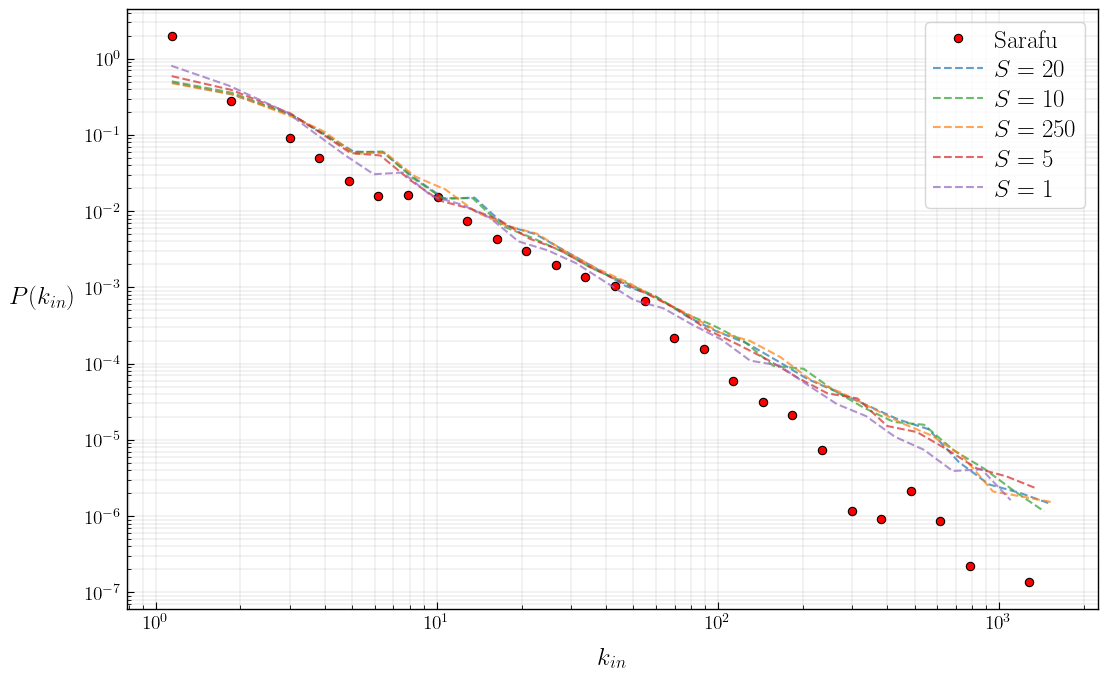

In [ ]:
hist_sarafu = histogram(sarafu['agents'].in_deg)

fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))

# 1) plottiamo Sarafu e lo mettiamo in legenda come voce speciale
sarafu_handle = ax.plot(hist_sarafu[0], hist_sarafu[1],
                        'ro', markeredgecolor='k', label='Sarafu')[0]


data = sim_results
# legend_dict = {s:[] for s in metadata_df['s'].unique()}
# qui salviamo le voci di legenda per le simulazioni
legend_entries = []   # conterrà tuple: (s_val, handle, label)

for i in range(len(data)):
    s = data[i]['metadata']['s']
    color = colors_dict_s[s]
    h = histogram(data[i]['agents']['in_deg'], log_bin=True, num_bins=nbins)

    # plottiamo e ci teniamo l'handle
    line, = ax.plot(
        h[0], h[1],
        linestyle='--',
        color=color,
        alpha=0.7,
        label=f"$S={s}$"
    )

    # salviamo per la legenda
    legend_entries.append((s, line, f"$S={s}$"))
# ora ordiniamo SOLO le voci con s
legend_entries.sort(key=lambda x: x[0])   # crescente per s

# ricomponiamo handle e label: prima Sarafu, poi le s ordinate
handles = [sarafu_handle] + [e[1] for e in legend_entries]
labels  = ['Sarafu'] + [e[2] for e in legend_entries]


plt.loglog()
plt.xlabel(r'$k_{in}$')
plt.ylabel(r'$P(k_{in})$',rotation = 0,labelpad=30)
# plt.title("In Degree")
plt.grid(True,'both')

plt.legend()
# plt.show()
ax.tick_params(labelsize=14, pad=4)

save_figure(fig,f"{fig_path}/in_deg.png")

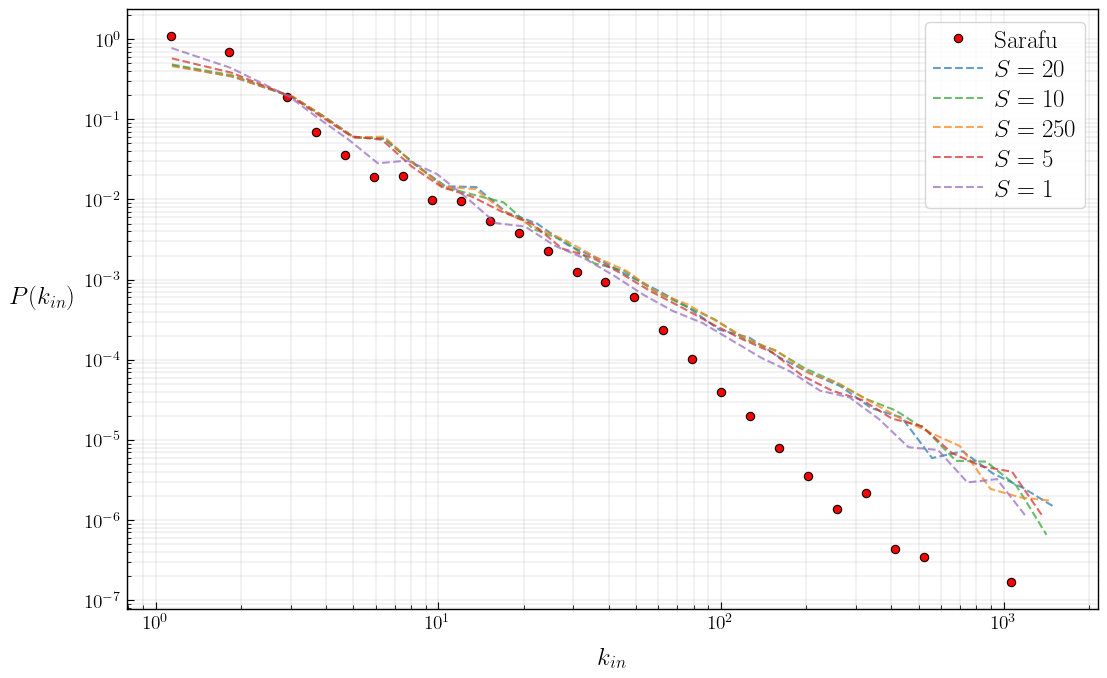

In [37]:
hist_sarafu = histogram(sarafu['agents'].out_deg)

fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))

# 1) plottiamo Sarafu e lo mettiamo in legenda come voce speciale
sarafu_handle = ax.plot(hist_sarafu[0], hist_sarafu[1],
                        'ro', markeredgecolor='k', label='Sarafu')[0]


data = sim_results
# legend_dict = {s:[] for s in metadata_df['s'].unique()}
# qui salviamo le voci di legenda per le simulazioni
legend_entries = []   # conterrà tuple: (s_val, handle, label)

for i in range(len(data)):
    s = data[i]['metadata']['s']
    color = colors_dict_s[s]
    h = histogram(data[i]['agents']['out_deg'], log_bin=True, num_bins=nbins)

    # plottiamo e ci teniamo l'handle
    line, = ax.plot(
        h[0], h[1],
        linestyle='--',
        color=color,
        alpha=0.7,
        label=f"$S={s}$"
    )

    # salviamo per la legenda
    legend_entries.append((s, line, f"$S={s}$"))
# ora ordiniamo SOLO le voci con s
legend_entries.sort(key=lambda x: x[0])   # crescente per s

# ricomponiamo handle e label: prima Sarafu, poi le s ordinate
handles = [sarafu_handle] + [e[1] for e in legend_entries]
labels  = ['Sarafu'] + [e[2] for e in legend_entries]


plt.loglog()
plt.xlabel(r'$k_{in}$')
plt.ylabel(r'$P(k_{in})$',rotation = 0,labelpad=30)
# plt.title("In Degree")
plt.grid(True,'both')

plt.legend()
# plt.show()
ax.tick_params(labelsize=14, pad=4)

save_figure(fig,f"{fig_path}/out_deg.png")

In [49]:
from adtxns_utils import find_key
from stats_utils import plot_scatter_kde

In [50]:
find_key(sim_results,1,1)

4

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_scatter_kde(
    data,
    ax=None,
    x_label="X",
    y_label="Y",
    log_scale=False,
    cmap="plasma",
    s=20,
    cbar_label="Density",
):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    xy = np.vstack([data[:, 0], data[:, 1]])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = data[:, 0][idx], data[:, 1][idx], z[idx]

    sc = ax.scatter(x, y, c=z, s=s, cmap=cmap, edgecolors="none")

    if log_scale:
        ax.set_xscale("log")
        ax.set_yscale("log")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # --- colorbar coerente con fixed_axes ---
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # 5% della larghezza
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label(cbar_label)

    return fig, ax


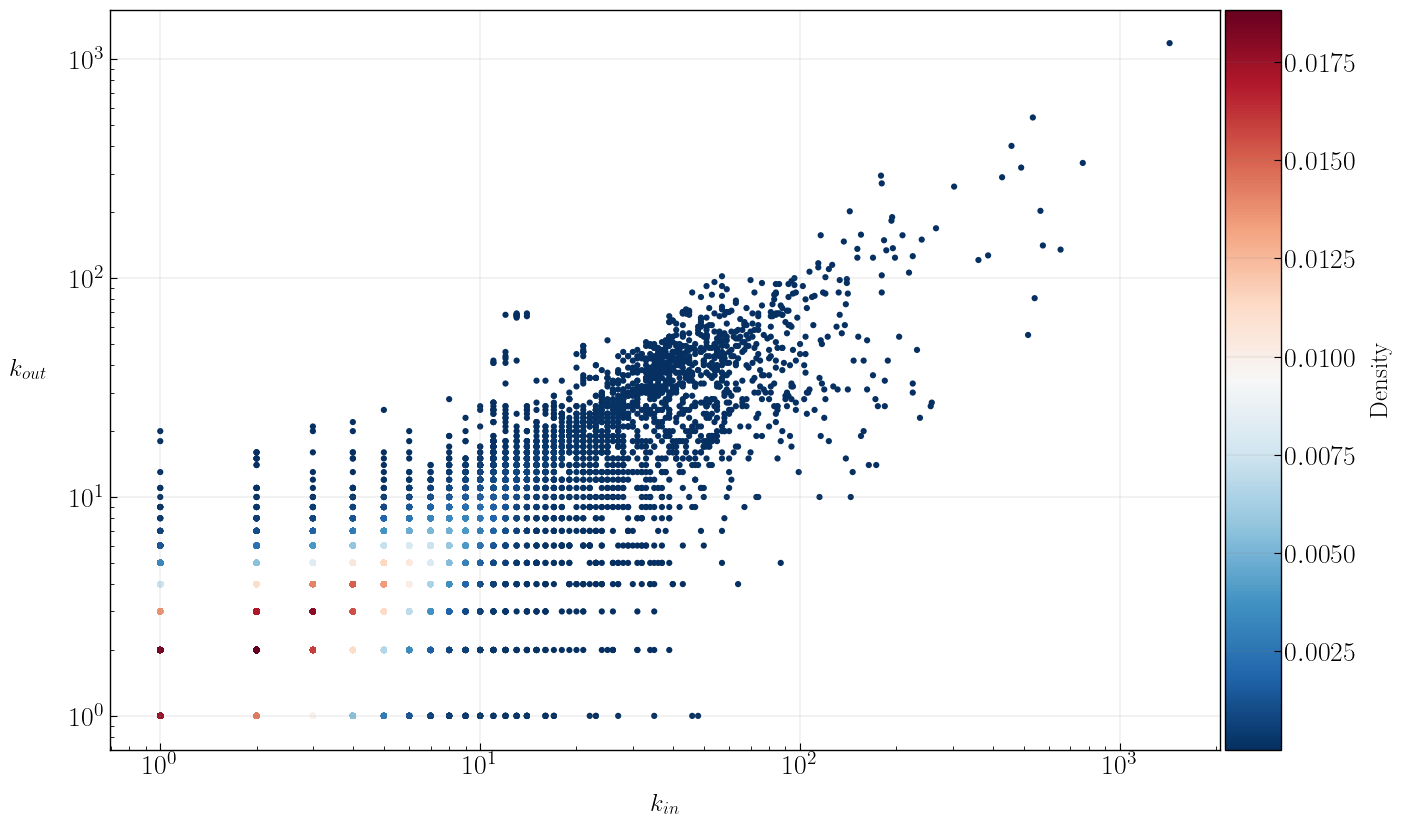

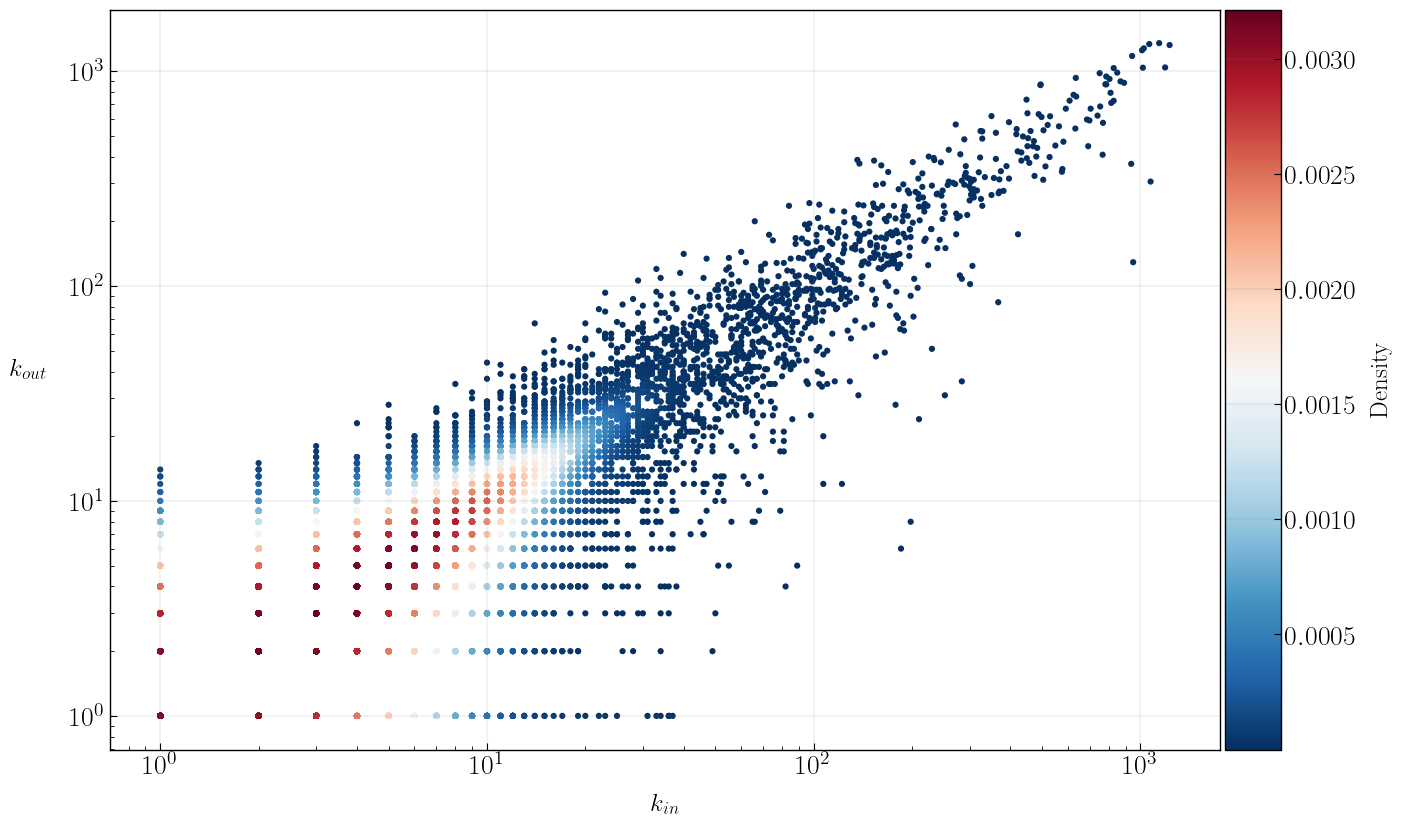

In [42]:
# parametri comuni
xlab = r"$k_{in}$"
ylab = r"$k_{out}$"

# 1. figura con assi fissi

sarafu_data = sarafu['agents'][['in_deg','out_deg']]
fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))
plot_scatter_kde(sarafu_data.values, x_label=xlab,log_scale=True,ax=ax,cmap='RdBu_r')
ax.set_ylabel(ylab,rotation=0,labelpad=30)
save_figure(fig,f"{fig_path}/kin_kout_corr_sarafu.png")



simulation_data = sim_results[4]['agents'][['in_deg','out_deg']]
fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))
plot_scatter_kde(simulation_data.values, x_label=xlab,log_scale=True,cmap='RdBu_r',ax=ax)
ax.set_ylabel(ylab,rotation=0,labelpad=30)
save_figure(fig,f"{fig_path}/kin_kout_corr_simu_s1.png")




In [49]:
find_key(metadata_df,0.25,1)

KeyError: 'b'

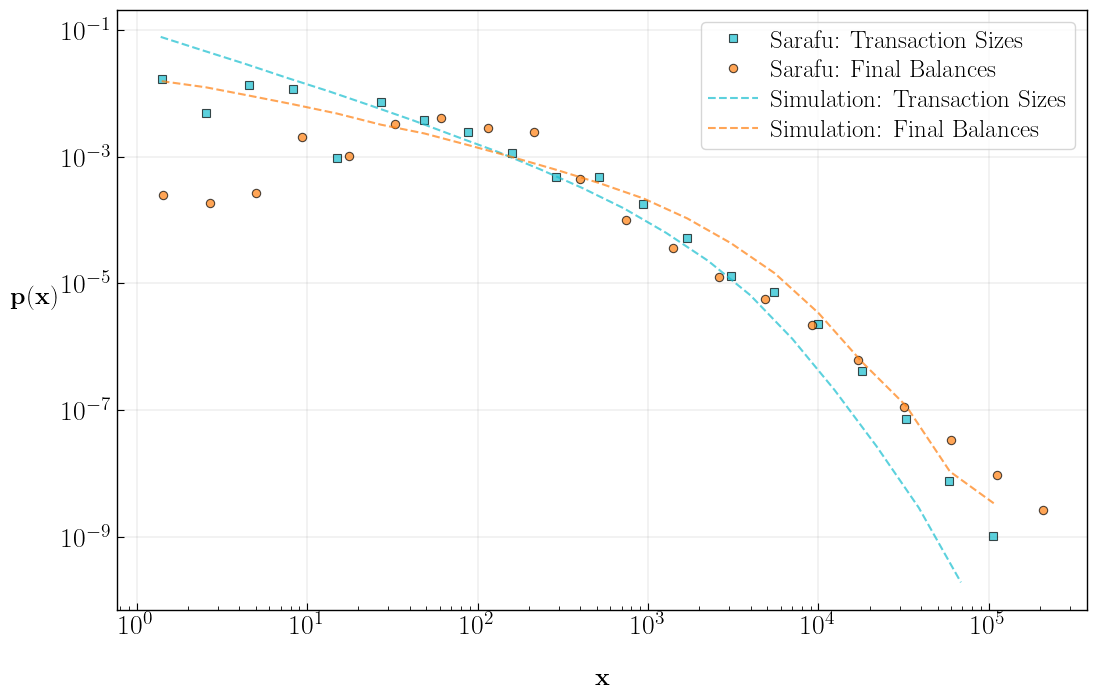

In [ ]:
nbins = 51
logbin = 1

# fig,ax = plt.subplots()
fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))


# Reference histograms (SARAFU data)
h1 = histogram(sarafu['transactions']['weight'], num_bins=21, log_bin=logbin)            
h3 = histogram(sarafu['balance_pivot'].iloc[:, -1].values, num_bins=21, log_bin=logbin)


ax.plot(h1[0], h1[1], c='tab:cyan', marker = 's',ls='', alpha=0.7, label='Sarafu: Transaction Sizes')
ax.plot(h3[0], h3[1], c='tab:orange', marker='o', ls='',alpha=0.7, label = "Sarafu: Final Balances")

data = sim_results
legend_dict = {b: [] for b in metadata_df['burstiness'].unique()}  # Store legend entries per `b`


h2 = histogram(data[find_key(0.25,1)]['transactions']['weight'], num_bins=21, log_bin=logbin)
h4 = histogram(data[find_key(0.25,1)]['balance_pivot'].iloc[:, -1].values, num_bins=21, log_bin=logbin)



marker = None
ax.plot(h2[0], h2[1], 
            marker=marker, 
            color='tab:cyan', 
            alpha=0.7,
            ls='--',
            label='Simulation: Transaction Sizes')  # Label only for legend sorting

ax.plot(h4[0], h4[1],
            marker=marker, 
            color='tab:orange',
            alpha=0.7,
            ls='--',
            label = "Simulation: Final Balances")

    

if logbin:
        ax.loglog()

ax.set_xlabel(r'$\bf{x}$', rotation=0, labelpad=20)
ax.set_ylabel(r'$\bf{p}(\bf{x})$', rotation=0, labelpad=20)
ax.legend()

save_figure(fig,f"{fig_path}/balance_weights_best.png")



In [ ]:
nbins = 51
logbin = 1

# fig,ax = plt.subplots()
fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))


# Reference histograms (SARAFU data)
h1 = histogram(sarafu['transactions']['weight'], num_bins=21, log_bin=logbin)            
h3 = histogram(sarafu['balance_pivot'].iloc[:, -1].values, num_bins=21, log_bin=logbin)


ax.plot(h1[0], h1[1], c='tab:cyan', marker = 's',ls='', alpha=0.7, label='Sarafu: Transaction Sizes')
ax.plot(h3[0], h3[1], c='tab:orange', marker='o', ls='',alpha=0.7, label = "Sarafu: Final Balances")

data = sim_results
legend_dict = {b: [] for b in metadata_df['burstiness'].unique()}  # Store legend entries per `b`


h2 = histogram(data[4]['transactions']['weight'], num_bins=21, log_bin=logbin)
h4 = histogram(data[4]['balance_pivot'].iloc[:, -1].values, num_bins=21, log_bin=logbin)



marker = None
ax.plot(h2[0], h2[1], 
            marker=marker, 
            color='tab:cyan', 
            alpha=0.7,
            ls='--',
            label='Simulation: Transaction Sizes')  # Label only for legend sorting

ax.plot(h4[0], h4[1],
            marker=marker, 
            color='tab:orange',
            alpha=0.7,
            ls='--',
            label = "Simulation: Final Balances")

    

if logbin:
        ax.loglog()

ax.set_xlabel(r'$\bf{x}$', rotation=0, labelpad=20)
ax.set_ylabel(r'$\bf{p}(\bf{x})$', rotation=0, labelpad=20)
ax.legend()

save_figure(fig,f"{fig_path}/balance_weights_best.png")



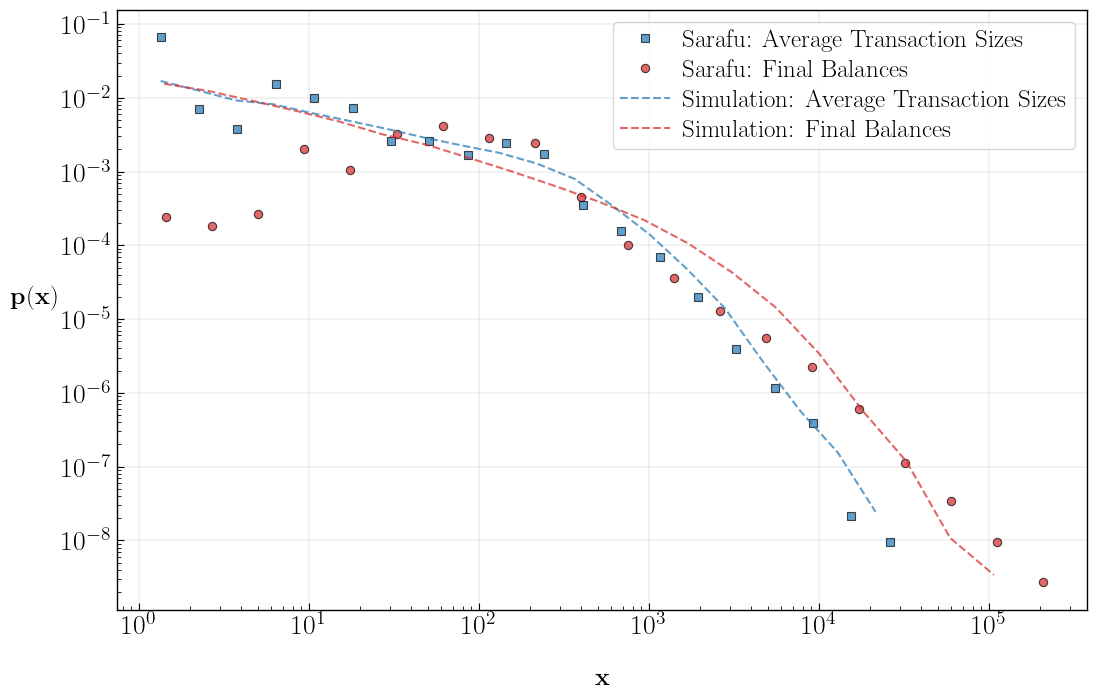

In [43]:
nbins = 51
logbin = 1

fig, ax = fixed_axes(margins=(1.2, 0.8, 1.0, 0.4))

# Reference histograms (SARAFU data)
h1 = histogram(sarafu['agents']['mean_exp'], num_bins=21, log_bin=logbin)            
h3 = histogram(sarafu['balance_pivot'].iloc[:, -1].values, num_bins=21, log_bin=logbin)


ax.plot(h1[0], h1[1], c='tab:blue', marker = 's',ls='', alpha=0.7, label='Sarafu: Average Transaction Sizes')
ax.plot(h3[0], h3[1], c='tab:red', marker='o', ls='',alpha=0.7, label = "Sarafu: Final Balances")

data = sim_results
legend_dict = {b: [] for b in metadata_df['burstiness'].unique()}  # Store legend entries per `b`


h2 = histogram(data[4]['agents']['mean_exp'], num_bins=21, log_bin=logbin)
h4 = histogram(data[4]['balance_pivot'].iloc[:, -1].values, num_bins=21, log_bin=logbin)



marker = None
ax.plot(h2[0], h2[1], 
            marker=marker, 
            color='tab:blue', 
            alpha=0.7,
            ls='--',
            label='Simulation: Average Transaction Sizes')  # Label only for legend sorting

ax.plot(h4[0], h4[1],
            marker=marker, 
            color='tab:red',
            alpha=0.7,
            ls='--',
            label = "Simulation: Final Balances")

    

if logbin:
        ax.loglog()

ax.set_xlabel(r'$\bf{x}$', rotation=0, labelpad=20)
ax.set_ylabel(r'$\bf{p}(\bf{x})$', rotation=0, labelpad=20)
ax.legend()
save_figure(fig,f"{fig_path}/balance_mean_weights_best.png")



In [54]:
import seaborn as sns

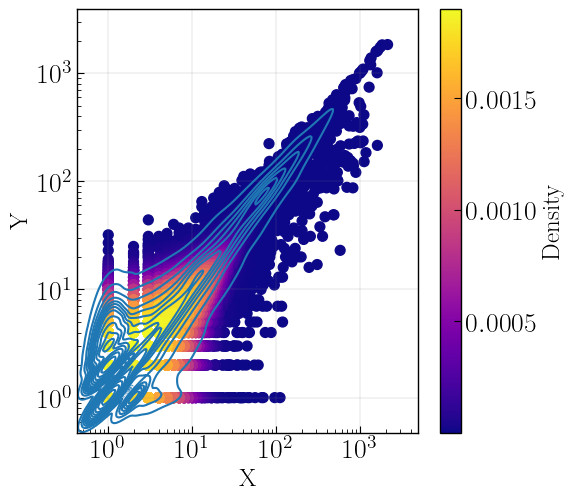

In [55]:
data = sarafu['agents']
h = sns.kdeplot(data,x="tx_in",y='tx_out',levels=15,log_scale=True)
plot_scatter_kde(data[['tx_in','tx_out']].values, ax=h, alpha=0.5)


In [56]:
sarafu['agents'].columns

Index(['crid', 'tx_in', 'vol_in', 'mean_earn', 'median_earn', 'max_earn',
       'min_earn', 'mean_frac_in', 'median_frac_in', 'max_frac_in',
       'min_frac_in', 'in_deg', 'first_txns_in', 'tx_out', 'vol_out',
       'mean_exp', 'median_exp', 'max_exp', 'min_exp', 'mean_frac_out',
       'median_frac_out', 'max_frac_out', 'min_frac_out', 'out_deg',
       'first_txns_out'],
      dtype='object')

In [57]:
from stats_utils import plot_scatter_kde

def plot_contour_kde(data, ax=None, x_label='X', y_label='Y', log_scale=False, cmap='plasma', levels=20, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    """
    Creates a filled contour plot (2D KDE) of the empirical joint density.
    Same interface as `plot_scatter_kde`.

    Parameters:
    - data: A 2D array or dataframe with two columns to be plotted.
    - ax: The matplotlib axes object to plot on.
    - x_label, y_label: Axis labels.
    - log_scale: If True, both axes will use a log scale.
    - cmap: Colormap for contours.
    - levels: Number of contour levels.
    - kwargs: Extra arguments passed to contourf.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Extract coordinates
    x, y = data[:, 0], data[:, 1]

    # KDE estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    
    # Grid definition
    xmin, xmax = np.percentile(x, [1, 99])
    ymin, ymax = np.percentile(y, [1, 99])
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Contour plot
    # cf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, **kwargs)
    ax.contour(X, Y, Z, levels=levels, colors=kwargs.get('countour_color','k'), linewidths=0.3, alpha=0.5)

    # Colorbar
    if kwargs.get('c_bar',False):
        cbar = plt.colorbar(cf, ax=ax)
        cbar.set_label('Density')

    # Labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Log scale (optional)
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')

    return fig,ax


In [58]:
matrix = data[i]['agents'][['in_deg','out_deg']].values
fig,ax = plot_contour_kde(matrix,contour_color=colors_dict_s[s])
ax.loglog()


KeyError: 4

In [ ]:
def plot_contour_kde(data, ax=None, x_label='X', y_label='Y',
                     log_scale=False, color='black', levels=15,
                     grid_points=200, bw_method=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    if ax is None:
        fig, ax = plt.subplots()

    x = np.asarray(data[:, 0], float)
    y = np.asarray(data[:, 1], float)

    # Rimuovi punti negativi se log
    if log_scale:
        mask = (x > 0) & (y > 0)
        x, y = x[mask], y[mask]

    # Stima KDE su griglia
    kde = gaussian_kde(np.vstack([x, y]), bw_method=bw_method)

    xmin, xmax = np.percentile(x, [1, 99])
    ymin, ymax = np.percentile(y, [1, 99])
    X, Y = np.mgrid[xmin:xmax:complex(grid_points), ymin:ymax:complex(grid_points)]
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Solo isolinee, stesso colore
    ax.contour(X, Y, Z, levels=levels, colors=color, linewidths=0.8)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')

    return ax


[]

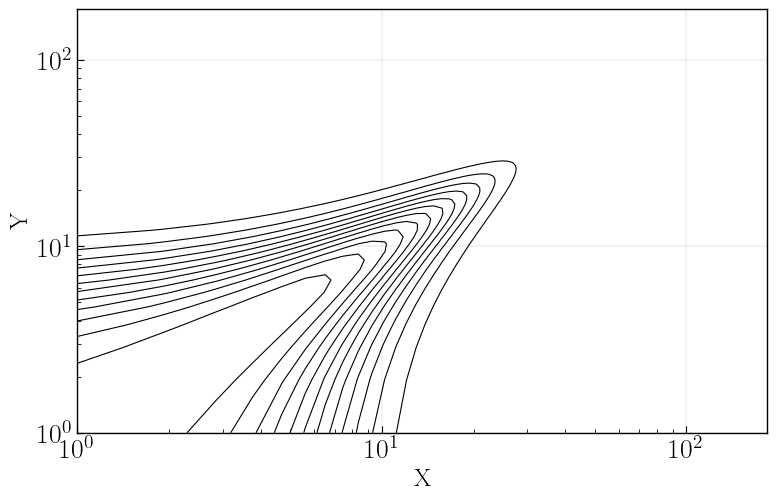

In [ ]:
matrix = data[i]['agents'][['in_deg','out_deg']].values
fig,ax = plt.subplots()
plot_contour_kde(matrix,ax=ax)
ax.loglog()

TypeError: plot_contour_kde() got an unexpected keyword argument 'c_bar'

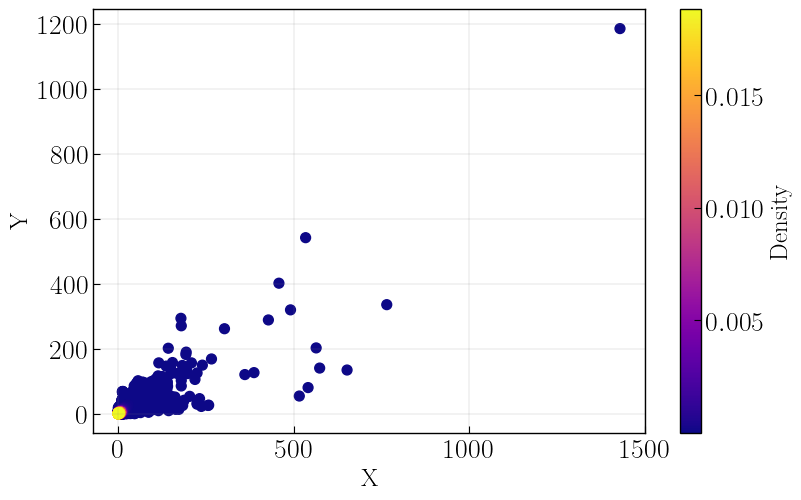

In [ ]:
data_sarafu = sarafu['agents'][['in_deg','out_deg']].values
fig,ax = plt.subplots()

plot_scatter_kde(data_sarafu,ax=ax)
data = sim_results
legend_dict = {s:[] for s in metadata_df['s'].unique()}

for i in range(len(data)):
    s = data[i]['metadata']['s']
    

    # ax = plots_dict[s][1]
    # fig = plots_dict[s][0]
    label = f'$s={s}$'
    # label = f"$k = {b:.2f}$"
    # marker = markers_dict_b[b]
    color = colors_dict_s[s]

    matrix = data[i]['agents'][['in_deg','out_deg']].values

    plot_contour_kde(matrix,ax=ax,c_bar=False)

plt.loglog()



In [ ]:
ax.loglog()
plt.show()

In [ ]:
import seaborn as sns
sns.

ValueError: Contour levels must be increasing

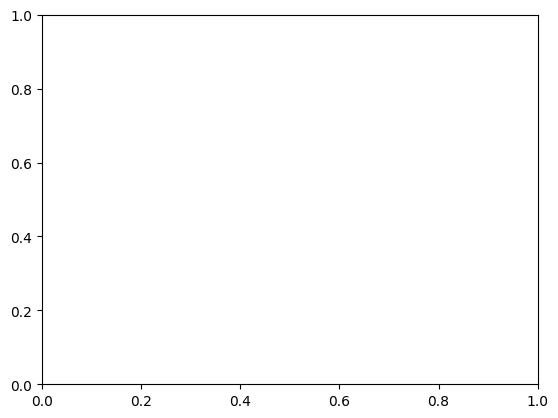

In [ ]:
matrix = data[i]['agents'][['in_deg','out_deg']]
ax = sns.kdeplot(matrix, x='in_deg', y='out_deg',)
ax.ax_joint.loglog()

In [ ]:
from mpl_toolkits.axes_grid1 import Divider, Size
import matplotlib.pyplot as plt

def fixed_axes(ax_w=6, ax_h=6, margins=(1.0, 1.0, 0.7, 0.3)):  
    """
    Crea una figura con assi di dimensione fissa in pollici.
    margins = (left, right, bottom, top) in pollici.
    """
    # dimensioni totali figura = area assi + margini
    fig_w = ax_w + margins[0] + margins[1]
    fig_h = ax_h + margins[2] + margins[3]

    fig = plt.figure(figsize=(fig_w, fig_h))
    divider = Divider(
        fig, (0, 0, 1, 1),
        horizontal=[Size.Fixed(margins[0]), Size.Fixed(ax_w), Size.Fixed(margins[1])],
        vertical=[Size.Fixed(margins[2]), Size.Fixed(ax_h), Size.Fixed(margins[3])]
    )

    ax = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1))
    return fig, ax


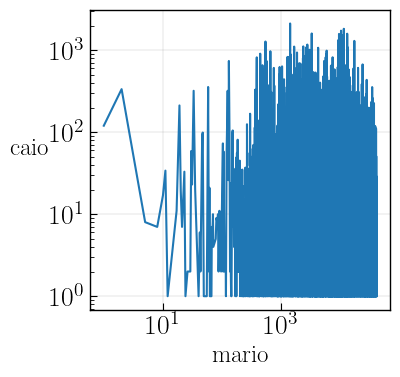

In [81]:
fig, ax = fixed_axes(3,3,(2,2,2,2))

ax.plot(sarafu['agents']['tx_in'])
ax.set_xlabel('mario')
ax.set_ylabel("caio",rotation=0,labelpad=15)
ax.loglog()
plt.show()
